<a href="https://colab.research.google.com/github/lexxai/goit_python_ds_hw_09/blob/main/goit_python_ds_hw_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Модуль 9. Підбір гіперпараметрів НМ

*З циклу [домашніх завдань Python Data Science](https://github.com/lexxai/goit_python_data_sciense_homework).*

# Домашнє завдання

## Про датасет Fashion-MNIST

Дану нейромережу ми будемо вивчати на датасеті Fashion-MNIST.
Fashion-MNIST - це набір даних зображень статей Zalando, що складається з навчального набору з 60 000 прикладів і тестового набору з 10 000 прикладів. Кожен приклад - це зображення 28x28 у відтінках сірого, пов'язане з міткою з 10 класів. Кожен піксель приймає значення від 0 до 255.

**Label	Description**

| Label | Clothing Item | --- | Label | Clothing Item | --- | Label | Clothing Item | --- | Label | Clothing Item | --- | Label | Clothing Item |
|-------|---------------|-----|-------|---------------|-----|-------|---------------|-----|-------|---------------|-----|-------|---------------|
| 0     | T-shirt/top   |     | 2     | Pullover      |     | 4     | Coat          |     | 6     | Shirt         |     | 8     | Bag           |
| 1     | Trouser       |     | 3     | Dress         |     | 5     | Sandal        |     | 7     | Sneaker       |     | 9     | Ankle boot    |





In [57]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout

from keras import optimizers, regularizers
from keras import losses, metrics
from keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoLocator, FixedLocator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

## Завантажуємо датасет

In [58]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import fashion_mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [59]:
num_classes = 10 # загальна кількість класів
learning_rate = 0.001 # швидкість навчання нейронної мережі
num_features = x_train.shape[1] * x_train.shape[2] # кількість атрибутів вхідного вектора 28 * 28 = 784
num_features

784

In [60]:
labels = ['T-shirt/top', 'Trouser', "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
labels_uk = ["Футболка/топ", "Штани", "Пуловер", "Сукня", "Пальто", "Босоніжки", "Сорочка", "Кросівки", "Сумка", "Черевики"]

In [61]:
# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

In [62]:
x_train.shape[1:]

(28, 28)

## Створення моделей НМ

In [63]:
n_hidden_1 = 256 # кількість нейронів 1-го шару
n_hidden_2 = 512 # кількість нейронів 2-го шару
n_hidden_3 = 16 # кількість нейронів 3-го шару

models = {}
models_his = {}
results = {}

In [64]:
def get_callbacks(name):
    # Define early stopping callback
    early_stopping_acc = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                          patience=accurqcy_patience,verbose=1,
                                                          restore_best_weights=True)

    early_stopping_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=loss_patience, verbose=1,
                                                           restore_best_weights=True, start_from_epoch=4)


    # Define model checkpoint callback to save the best model
    model_checkpoint_acc = tf.keras.callbacks.ModelCheckpoint(filepath=f"{name}_best_model_acc.h5",
                                                           monitor='val_accuracy',
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           verbose=1)
    model_checkpoint_loss = tf.keras.callbacks.ModelCheckpoint(filepath=f"{name}_best_model_loss.h5",
                                                           monitor='val_loss',
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           verbose=1)

    return [early_stopping_loss, early_stopping_acc, model_checkpoint_acc, model_checkpoint_loss]


def compile_and_fit(model, name, batch_size=512, learning_rate=0.001, max_epochs=10000):
  model.compile(
      optimizer=optimizers.Adam(learning_rate=learning_rate),
      loss='sparse_categorical_crossentropy',
      metrics=["accuracy"]
  )
  model.summary()
  history = model.fit(
      x_train,
      y_train,
      #initial_epoch=0,
      epochs=max_epochs,
      batch_size=batch_size,
      validation_data=(x_test, y_test),
      callbacks=get_callbacks(name),
      use_multiprocessing=True
  )
  return history

## Додаємо першу модель НМ версія 1 (IL-HL1-HL2-HL3-HL4-OL) з регулярізацією L2 (0.025) в "HL2", ативаційна функція 'relu'

In [65]:
model_name = "Model_1_L2_0.025"

kernel_regularizer=regularizers.l2(0.025)

models[model_name] = Sequential([
    # Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
    # MaxPooling2D(2, 2),
    # Flatten(), leaky_relu
    Flatten(input_shape=x_train.shape[1:], name="INPUT"),
    Dense(n_hidden_1, activation='relu', name="Hidden_Layer_1"),
    # Dropout(0.5),
    Dense(n_hidden_2, activation='relu', kernel_regularizer=kernel_regularizer, name="Hidden_Layer_2"),
    Dense(256, activation='relu', name="Hidden_Layer_3"),
    Dense(32, activation='relu', name="Hidden_Layer_4"),
    # Dense(n_hidden_3, activation='relu', name="Hidden_Layer_3"),
    Dense(num_classes, activation='softmax', name="OUTPUT"),
],name=model_name)

# model.compile(
#     optimizer=optimizers.Adam(learning_rate=learning_rate),
#     loss='sparse_categorical_crossentropy',
#     metrics=["accuracy"]
# )

# model.summary()
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Навчання першої моделі НМ

In [66]:
batch_size = 512 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
epochs = 60
accurqcy_patience = 10
loss_patience = 5

models[model_name].reset_states()
models_his[model_name] = compile_and_fit(models[model_name], model_name, batch_size=batch_size, max_epochs=epochs)

Model: "Model_1_L2_0.025"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (Flatten)             (None, 784)               0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 256)               200960    
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               131584    
                                                                 
 Hidden_Layer_3 (Dense)      (None, 256)               131328    
                                                                 
 Hidden_Layer_4 (Dense)      (None, 32)                8224      
                                                                 
 OUTPUT (Dense)              (None, 10)                330       
                                                                 
Total params: 472426 (1.80 MB)
Trainable params: 4

## Аналіз результатів першої моделі

In [67]:
results[model_name] = models[model_name].evaluate(x_test, y_test, verbose=True)
print(results[model_name])

313/313 [==============================] - 1s 3ms/step - loss: 0.3583 - accuracy: 0.8879
[0.358311265707016, 0.8878999948501587]


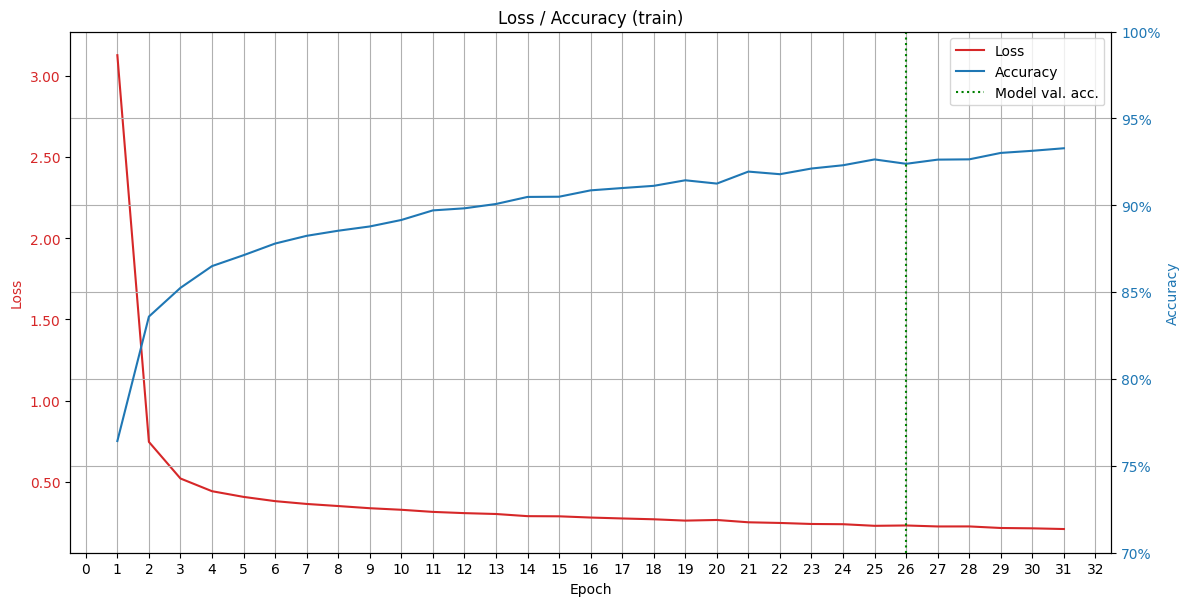

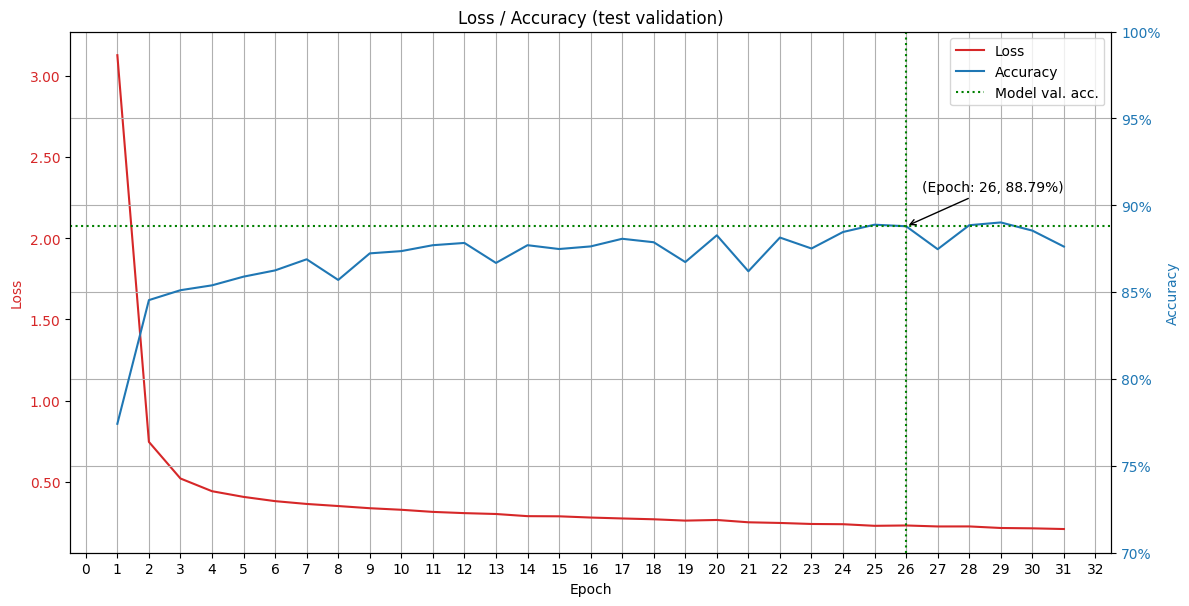

In [68]:
def pair_plot(loss_history, accuracy_history, title, closest_index = None, model_accuracy=None):

  fig, ax1 = plt.subplots()
  fig.set_size_inches((12,6))

  color = 'tab:red'
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss', color=color)
  ax1.plot(loss_history, color=color, label="Loss")
  ax1.tick_params(axis='y', labelcolor=color)
  ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int((x + 1))))
  if len(loss_history) < 40 :
    ax1.xaxis.set_major_locator(MultipleLocator(1))
  ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{(y):.2f}'))
  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  color = 'tab:blue'
  ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
  p2=ax2.plot(accuracy_history, color=color, label="Accuracy")
  ax2.tick_params(axis='y', labelcolor=color)
  ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
  ax2.grid()
  ax1.xaxis.grid(True)
  ax2.set_ylim([0.7, 1.0])

  if closest_index:
    ax2.axvline(x=closest_index, color='green', linestyle='dotted', label="Model val. acc.")
    if model_accuracy:
      ax2.axhline(y=model_accuracy, color='green', linestyle='dotted')
      intersection_text = f'(Epoch: {closest_index+1}, {model_accuracy:.2%})'
      ax2.annotate(intersection_text, xy=(closest_index, model_accuracy), xytext=(closest_index + 0.5, model_accuracy + 0.02),
                  arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)


  # Combine the legends from ax1 and ax2
  lines, labels_ = ax1.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels_ + labels2, loc='best')

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.title(title)
  plt.show()

loss_history = models_his[model_name].history['loss']
accuracy_history = models_his[model_name].history['accuracy']
val_loss_history = models_his[model_name].history['loss']
val_accuracy_history = models_his[model_name].history['val_accuracy']

closest_epoch_index = np.argmin(np.abs(np.array(val_accuracy_history) - results[model_name][1]))


pair_plot(loss_history, accuracy_history, "Loss / Accuracy (train)", closest_epoch_index)
pair_plot(val_loss_history, val_accuracy_history, "Loss / Accuracy (test validation)", closest_epoch_index, results[model_name][1])

## Додаємо модель НМ версію 1 (IL-HL1-HL2-HL3-HL4-OL) без регулярізації L2 в "HL2"

In [69]:
model_name = "Model_1_no_reg"

models[model_name] = Sequential([
    Flatten(input_shape=x_train.shape[1:], name="INPUT"),
    Dense(n_hidden_1, activation='relu', name="Hidden_Layer_1"),
    Dense(n_hidden_2, activation='relu', kernel_regularizer=None, name="Hidden_Layer_2"),
    Dense(256, activation='relu', name="Hidden_Layer_3"),
    Dense(32, activation='relu', name="Hidden_Layer_4"),
    Dense(num_classes, activation='softmax', name="OUTPUT"),
],name=model_name)

models_his[model_name]  = compile_and_fit(models[model_name], model_name, batch_size=batch_size, max_epochs=epochs)
results[model_name] = models[model_name].evaluate(x_test, y_test, verbose=True)
print(results[model_name])

Model: "Model_1_no_reg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (Flatten)             (None, 784)               0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 256)               200960    
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               131584    
                                                                 
 Hidden_Layer_3 (Dense)      (None, 256)               131328    
                                                                 
 Hidden_Layer_4 (Dense)      (None, 32)                8224      
                                                                 
 OUTPUT (Dense)              (None, 10)                330       
                                                                 
Total params: 472426 (1.80 MB)
Trainable params: 472

## Додаємо нову модель НМ версія 1 (IL-HL1-HL2-HL3-HL4-OL) з регулярізацією L2 0.1 в "HL2"

In [70]:
model_name = "Model_1_L2_0.1"

kernel_regularizer_1 = regularizers.l2(0.1)

models[model_name] = Sequential([
    Flatten(input_shape=x_train.shape[1:], name="INPUT"),
    Dense(n_hidden_1, activation='relu', name="Hidden_Layer_1"),
    Dense(n_hidden_2, activation='relu', kernel_regularizer=kernel_regularizer_1, name="Hidden_Layer_2"),
    Dense(256, activation='relu', name="Hidden_Layer_3"),
    Dense(32, activation='relu', name="Hidden_Layer_4"),
    Dense(num_classes, activation='softmax', name="OUTPUT"),
],name=model_name)

models_his[model_name] = compile_and_fit(models[model_name], model_name, batch_size=batch_size, max_epochs=epochs)
results[model_name] = models[model_name].evaluate(x_test, y_test, verbose=True)
print(results[model_name])

Model: "Model_1_L2_0.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (Flatten)             (None, 784)               0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 256)               200960    
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               131584    
                                                                 
 Hidden_Layer_3 (Dense)      (None, 256)               131328    
                                                                 
 Hidden_Layer_4 (Dense)      (None, 32)                8224      
                                                                 
 OUTPUT (Dense)              (None, 10)                330       
                                                                 
Total params: 472426 (1.80 MB)
Trainable params: 472

## Додаємо нову модель НМ версія 2 (IL-HL1-HL2-OL), ативаційна функція 'relu'

In [71]:
model_name = "Model_2"

models[model_name] = Sequential([
    Flatten(input_shape=x_train.shape[1:], name="INPUT"),
    Dense(n_hidden_1, activation='relu', name="Hidden_Layer_1"),
    Dense(n_hidden_2, activation='relu', kernel_regularizer=None, name="Hidden_Layer_2"),
    Dense(num_classes, activation='softmax', name="OUTPUT"),
],name=model_name)

models_his[model_name] = compile_and_fit(models[model_name], model_name, batch_size=batch_size, max_epochs=epochs)
results[model_name] = models[model_name].evaluate(x_test, y_test, verbose=True)
print(results[model_name])

Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (Flatten)             (None, 784)               0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 256)               200960    
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               131584    
                                                                 
 OUTPUT (Dense)              (None, 10)                5130      
                                                                 
Total params: 337674 (1.29 MB)
Trainable params: 337674 (1.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/60
117/118 [============================>.] - ETA: 0s - loss: 0.6097 - accuracy: 0.7884
Epoch 1: val_accuracy improved from -inf to 0.82190, saving

## Додаємо нову модель НМ версія 2 (IL-HL1-HL2-OL) L2 (0.1)

In [72]:
model_name = "Model_2_L2_0.1"

kernel_regularizer_2 = regularizers.l2(0.1)

models[model_name] = Sequential([
    Flatten(input_shape=x_train.shape[1:], name="INPUT"),
    Dense(n_hidden_1, activation='relu', name="Hidden_Layer_1"),
    Dense(n_hidden_2, activation='relu', kernel_regularizer=kernel_regularizer_2, name="Hidden_Layer_2"),
    Dense(num_classes, activation='softmax', name="OUTPUT"),
],name=model_name)

history = compile_and_fit(models[model_name], model_name, batch_size=batch_size, max_epochs=epochs)
models_his[model_name] = history
results[model_name] = models[model_name].evaluate(x_test, y_test, verbose=True)
print(results[model_name])

Model: "Model_2_L2_0.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (Flatten)             (None, 784)               0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 256)               200960    
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               131584    
                                                                 
 OUTPUT (Dense)              (None, 10)                5130      
                                                                 
Total params: 337674 (1.29 MB)
Trainable params: 337674 (1.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/60
116/118 [============================>.] - ETA: 0s - loss: 8.3801 - accuracy: 0.7520
Epoch 1: val_accuracy improved from -inf to 0.77400,

## Додаємо нову модель НМ версія 2 (IL-HL1-HL2-OL) з L2 (1.0)

In [73]:
model_name = "Model_2_L2_1"

kernel_regularizer_2 = regularizers.l2(1)

models[model_name] = Sequential([
    Flatten(input_shape=x_train.shape[1:], name="INPUT"),
    Dense(n_hidden_1, activation='relu', name="Hidden_Layer_1"),
    Dense(n_hidden_2, activation='relu', kernel_regularizer=kernel_regularizer_2, name="Hidden_Layer_2"),
    Dense(num_classes, activation='softmax', name="OUTPUT"),
],name=model_name)

history = compile_and_fit(models[model_name], model_name, batch_size=batch_size, max_epochs=epochs)
models_his[model_name] = history
results[model_name] = models[model_name].evaluate(x_test, y_test, verbose=True)
print(results[model_name])

Model: "Model_2_L2_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (Flatten)             (None, 784)               0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 256)               200960    
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               131584    
                                                                 
 OUTPUT (Dense)              (None, 10)                5130      
                                                                 
Total params: 337674 (1.29 MB)
Trainable params: 337674 (1.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/60
116/118 [============================>.] - ETA: 0s - loss: 74.3303 - accuracy: 0.7352
Epoch 1: val_accuracy improved from -inf to 0.74790, 

## Додаємо нову модель НМ версія 3 (IL-HL1-HL2-OL) з Dropout (0.2)

In [74]:
model_name = "Model_3_DO_0.2"
dropout_prob = 0.2

models[model_name] = Sequential([
    Flatten(input_shape=x_train.shape[1:], name="INPUT"),
    Dropout(dropout_prob),
    Dense(n_hidden_1, activation='relu', name="Hidden_Layer_1"),
    Dropout(dropout_prob),
    Dense(n_hidden_2, activation='relu',  name="Hidden_Layer_2"),
    Dropout(dropout_prob),
    Dense(num_classes, activation='softmax', name="OUTPUT"),
],name=model_name)

history = compile_and_fit(models[model_name], model_name, batch_size=batch_size, max_epochs=epochs)
models_his[model_name] = history
results[model_name] = models[model_name].evaluate(x_test, y_test, verbose=True)
print(results[model_name])

Model: "Model_3_DO_0.2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (Flatten)             (None, 784)               0         
                                                                 
 dropout_6 (Dropout)         (None, 784)               0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 256)               200960    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               131584    
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 OUTPUT (Dense)              (None, 10)             

## Додаємо нову модель НМ версія 3 (IL-HL1-HL2-OL) з Dropout (0.5)

In [75]:
model_name = "Model_3_DO_0.5"
dropout_prob = 0.5

models[model_name] = Sequential([
    Flatten(input_shape=x_train.shape[1:], name="INPUT"),
    Dropout(dropout_prob),
    Dense(n_hidden_1, activation='relu', name="Hidden_Layer_1"),
    Dropout(dropout_prob),
    Dense(n_hidden_2, activation='relu',  name="Hidden_Layer_2"),
    Dropout(dropout_prob),
    Dense(num_classes, activation='softmax', name="OUTPUT"),
],name=model_name)

history = compile_and_fit(models[model_name], model_name, batch_size=batch_size, max_epochs=epochs)
models_his[model_name] = history
results[model_name] = models[model_name].evaluate(x_test, y_test, verbose=True)
print(results[model_name])

Model: "Model_3_DO_0.5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (Flatten)             (None, 784)               0         
                                                                 
 dropout_9 (Dropout)         (None, 784)               0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 256)               200960    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               131584    
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 OUTPUT (Dense)              (None, 10)             

## Додаємо нову модель НМ версія 2 (IL-HL1-HL2-OL) з функцією активації leaky_relu

In [ ]:
model_name = "Model_2_lrelu"

models[model_name] = Sequential([
    Flatten(input_shape=x_train.shape[1:], name="INPUT"),
    Dense(n_hidden_1, activation='leaky_relu', name="Hidden_Layer_1"),
    Dense(n_hidden_2, activation='leaky_relu',  name="Hidden_Layer_2"),
    Dense(num_classes, activation='softmax', name="OUTPUT"),
],name=model_name)

history = compile_and_fit(models[model_name], model_name, batch_size=batch_size, max_epochs=epochs)
models_his[model_name] = history
results[model_name] = models[model_name].evaluate(x_test, y_test, verbose=True)
print(results[model_name])

Model: "Model_2_lrelu"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (Flatten)             (None, 784)               0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 256)               200960    
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               131584    
                                                                 
 OUTPUT (Dense)              (None, 10)                5130      
                                                                 
Total params: 337674 (1.29 MB)
Trainable params: 337674 (1.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/60
118/118 [==============================] - ETA: 0s - loss: 0.5928 - accuracy: 0.7965
Epoch 1: val_accuracy improved from -inf to 0.81930, 

## Сумарний звіт

In [84]:
def summarize(h, name, results=None):
    print(f"Summarize for: {name}")
    # plot loss
    closest_epoch_index = None
    if results:
      closest_epoch_index_val_loss = np.argmin(np.abs(np.array(h.history['val_loss']) - results[0]))
      closest_epoch_index_val_acc = np.argmin(np.abs(np.array(h.history['val_accuracy']) - results[1]))
      closest_epoch_index = min(closest_epoch_index_val_loss, closest_epoch_index_val_acc)
      print(f"{closest_epoch_index=}")

    plt.figure(figsize=(12,8))
    plt.subplot(2, 1, 1)
    plt.title(f'Cross Entropy Loss {name}')
    if closest_epoch_index:
      plt.axvline(x=closest_epoch_index, color='green', linestyle='dotted', label=f"Early stop: {closest_epoch_index+1}")
    plt.plot(h.history['loss'], color='blue', label='train')
    plt.plot(h.history['val_loss'], "--", color='orange', label='test')
    axis = plt.gca()
    axis.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int((x + 1))))
    max_x_value = len(h.history['loss'])
    if max_x_value < 55:
      axis.xaxis.set_major_locator(FixedLocator(range(0, max_x_value)))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0,1)
    plt.xlim(0,max_x_value-1)
    plt.legend()
    plt.grid()
    plt.tight_layout(pad=3.0)
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title(f'Classification Accuracy {name}')
    if closest_epoch_index:
      plt.axvline(x=closest_epoch_index, color='green', linestyle='dotted', label=f"Early stop: {closest_epoch_index+1}")
    plt.plot(h.history['accuracy'], color='blue', label='train')
    plt.plot(h.history['val_accuracy'], "--", color='orange', label='test')
    axis = plt.gca()
    axis.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int((x + 1))))
    if max_x_value < 55:
      axis.xaxis.set_major_locator(FixedLocator(range(0, max_x_value)))
    axis.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0.7,1)
    plt.xlim(0,max_x_value-1)
    plt.grid()
    plt.show()

Summarize for: (Model_1_L2_0.025)
closest_epoch_index=25


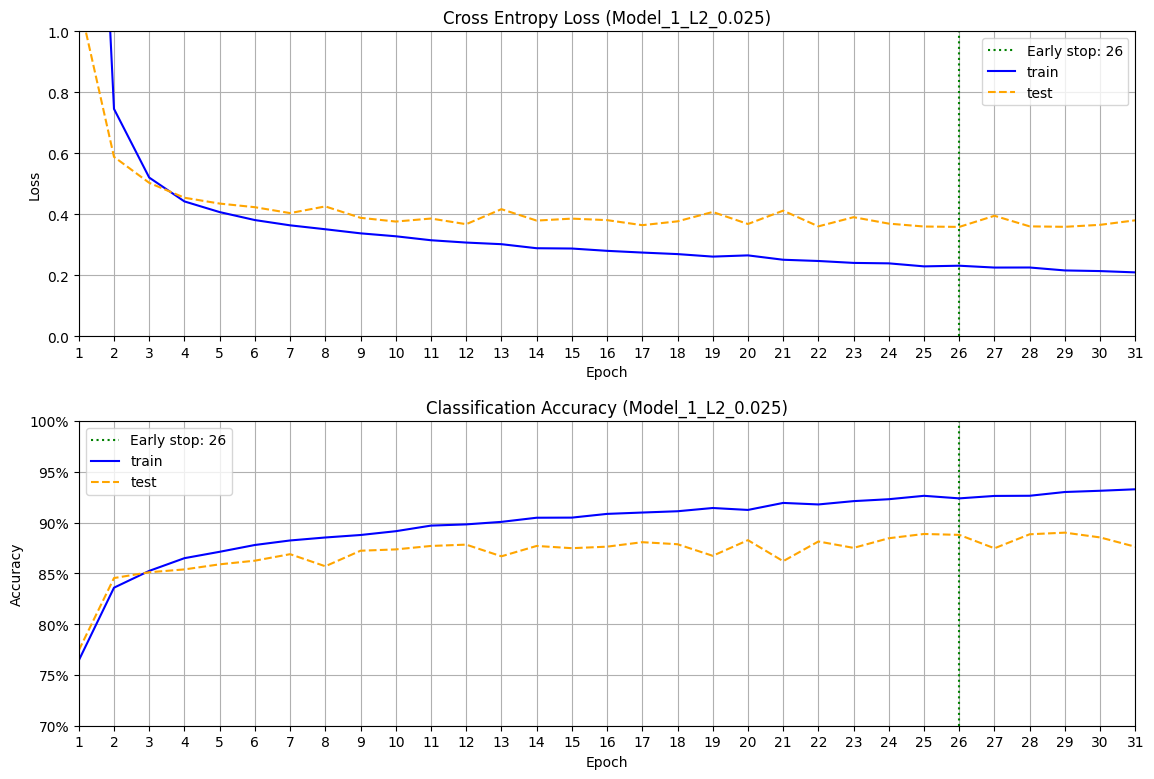

Summarize for: (Model_1_no_reg)
closest_epoch_index=8


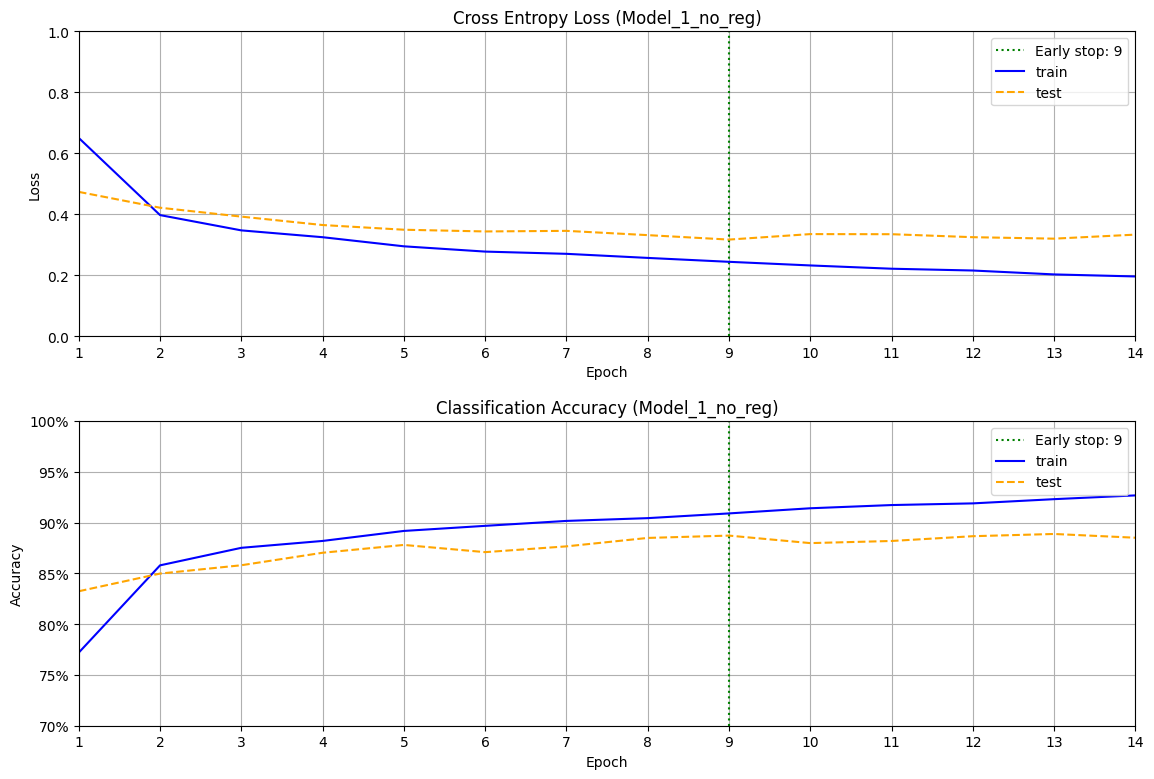

Summarize for: (Model_1_L2_0.1)
closest_epoch_index=21


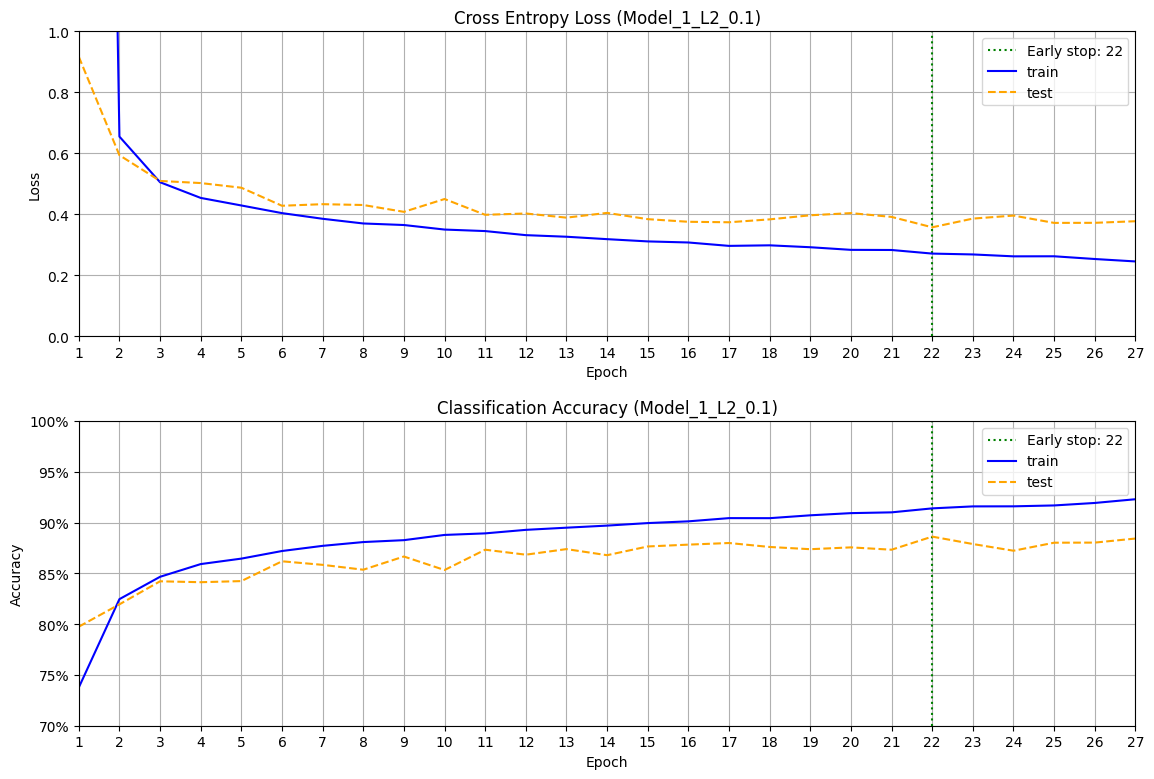

Summarize for: (Model_2)
closest_epoch_index=7


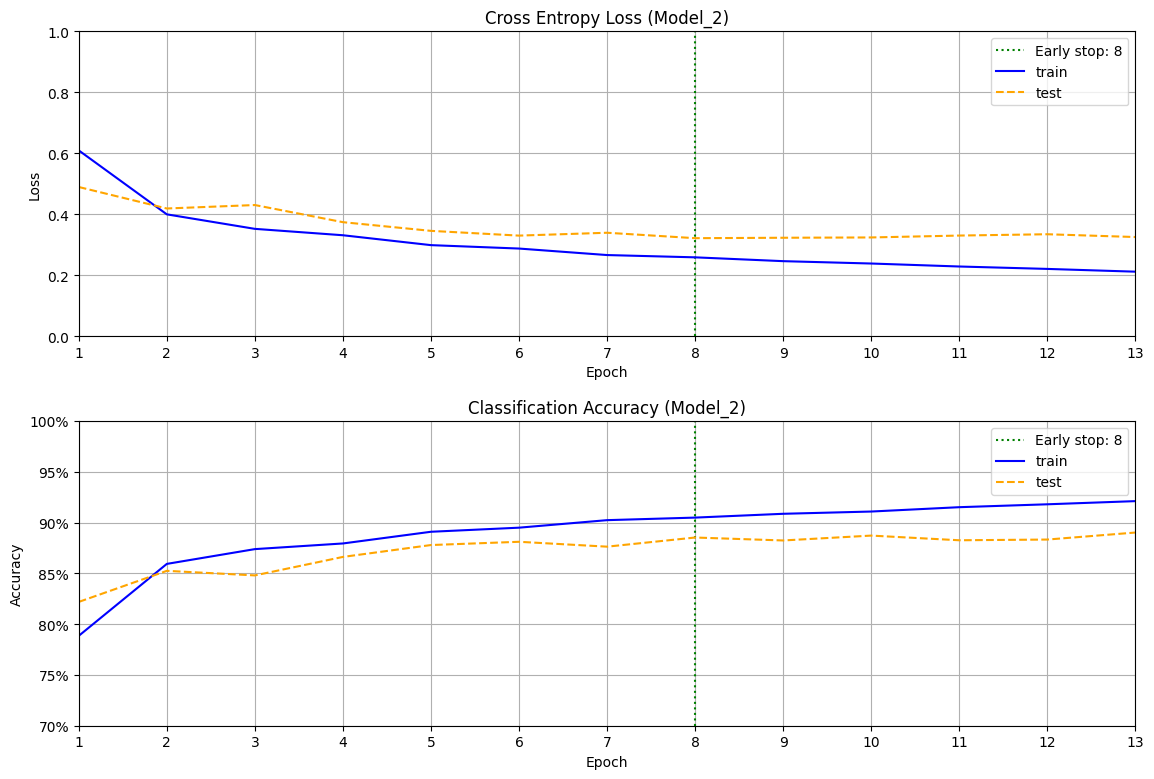

Summarize for: (Model_2_L2_0.1)
closest_epoch_index=25


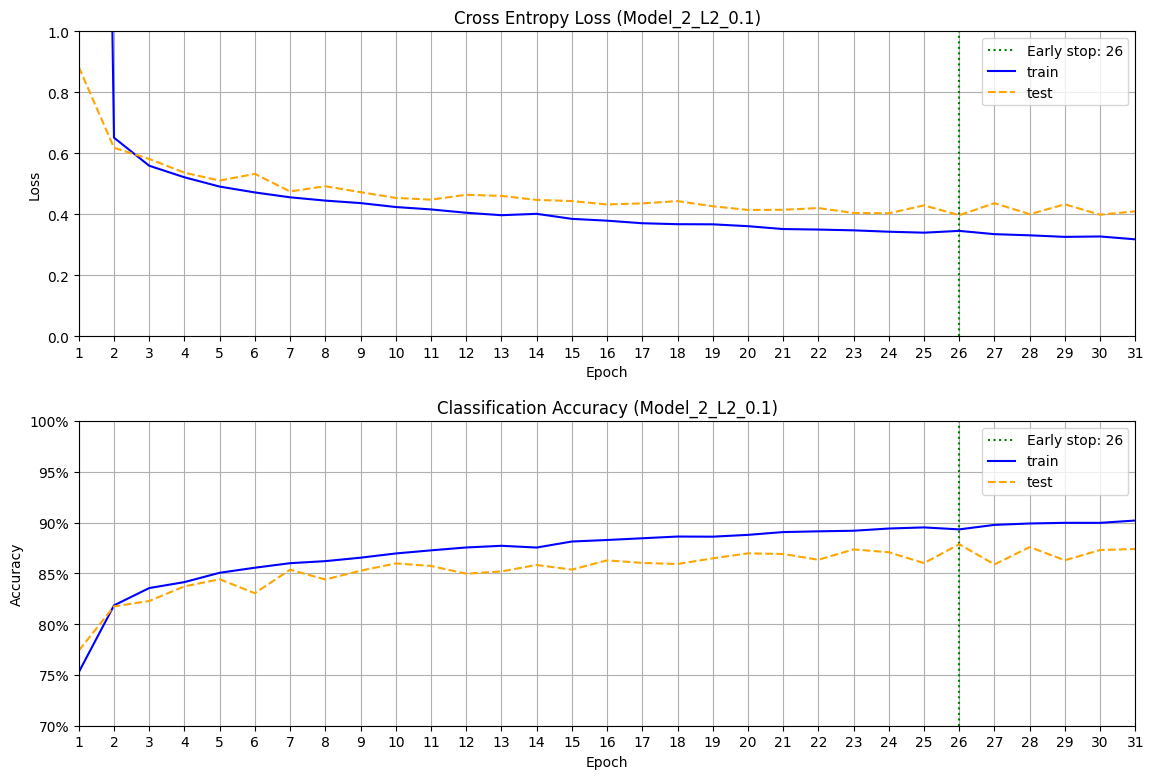

Summarize for: (Model_2_L2_1)
closest_epoch_index=24


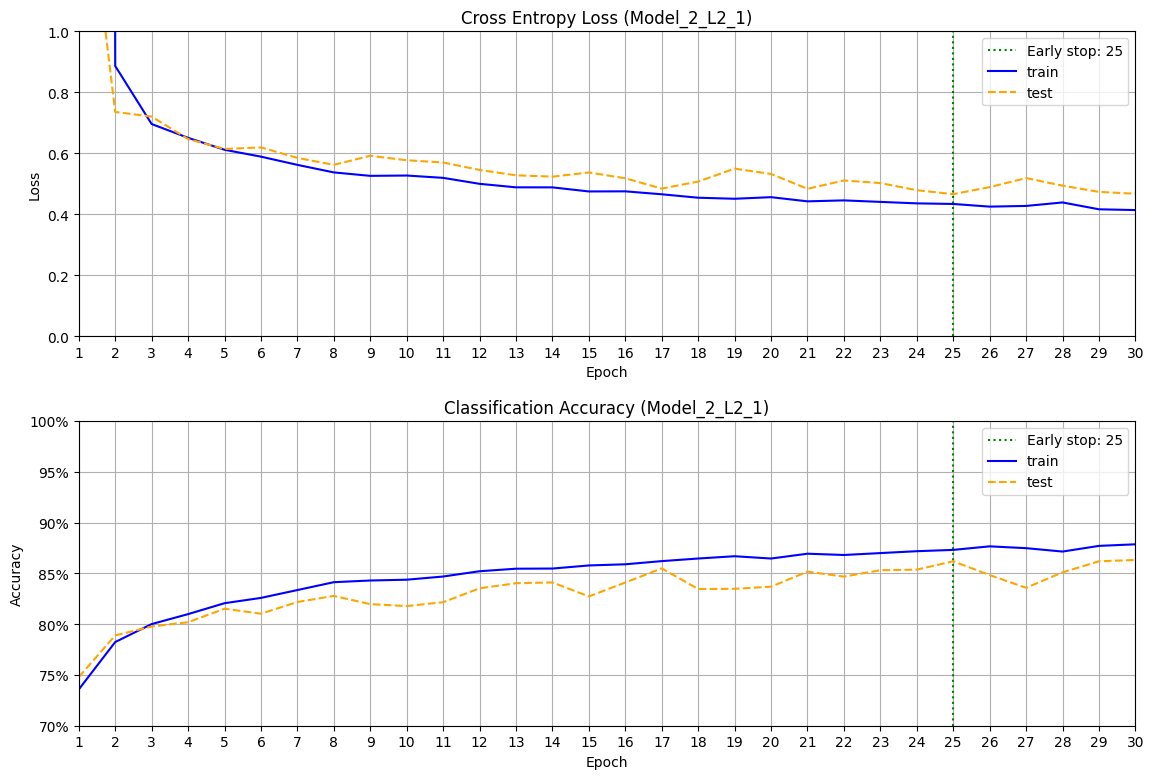

Summarize for: (Model_3_DO_0.2)
closest_epoch_index=22


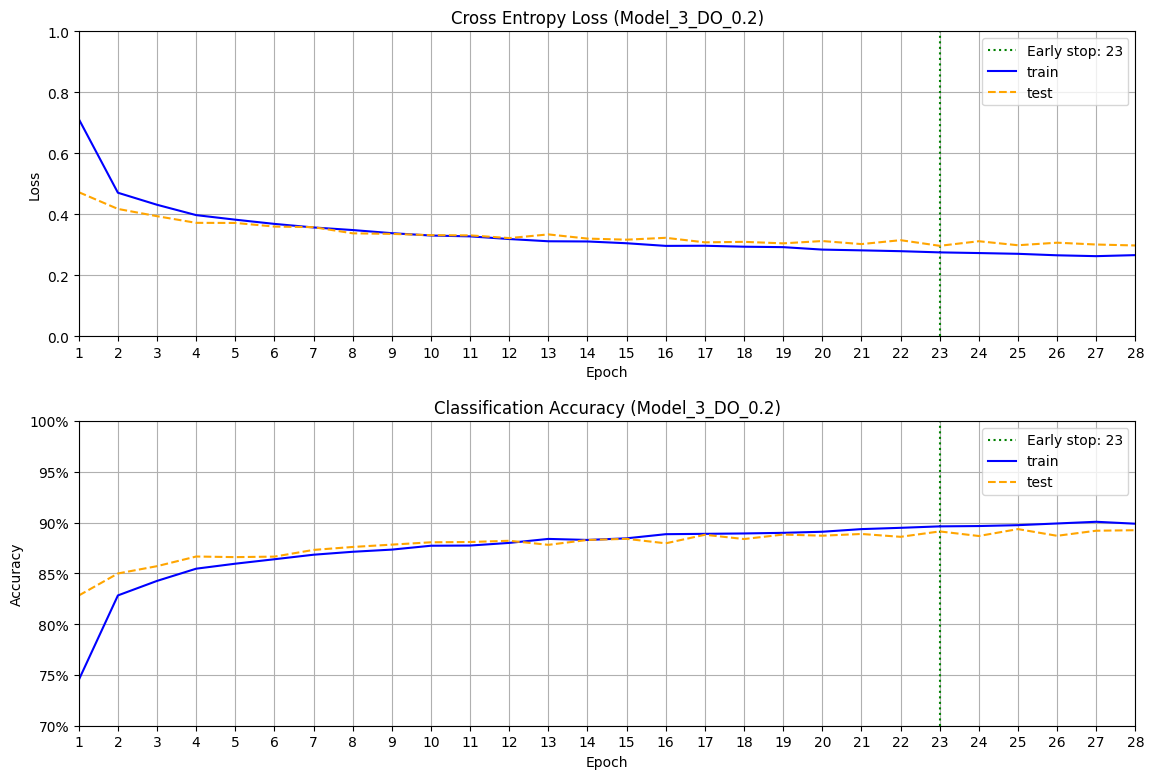

Summarize for: (Model_3_DO_0.5)
closest_epoch_index=48


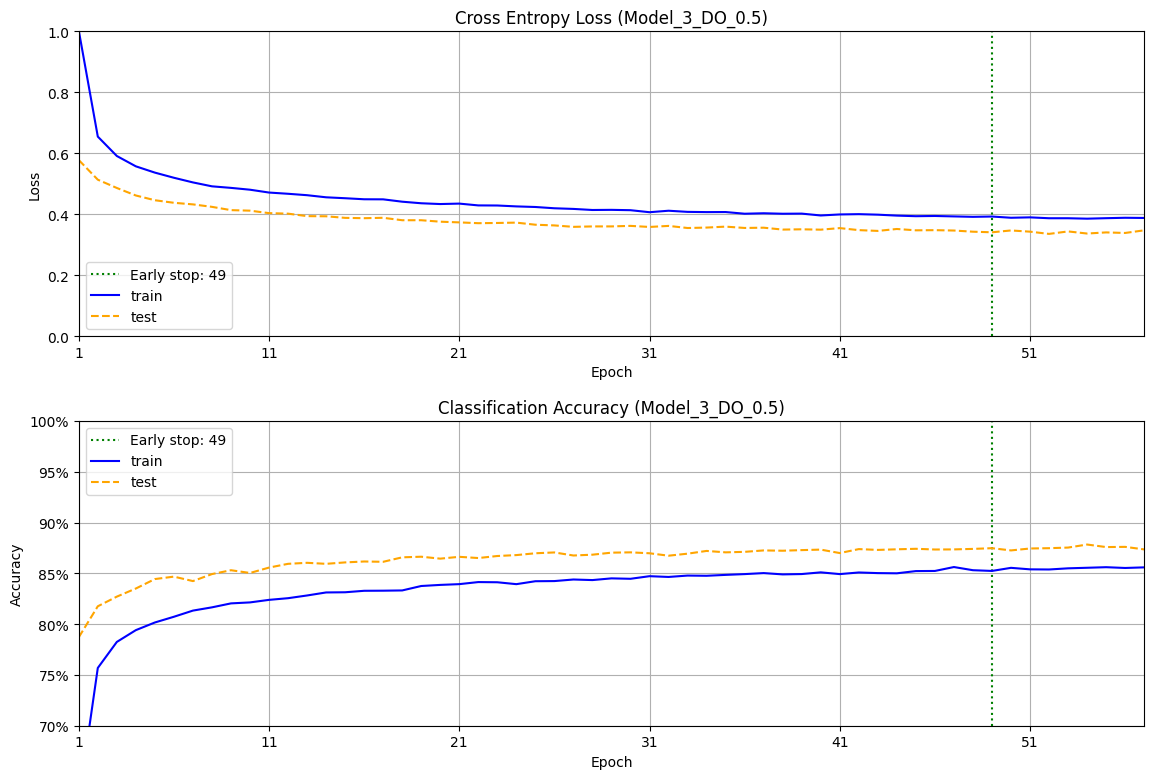

Summarize for: (Model_2_lrelu)
closest_epoch_index=17


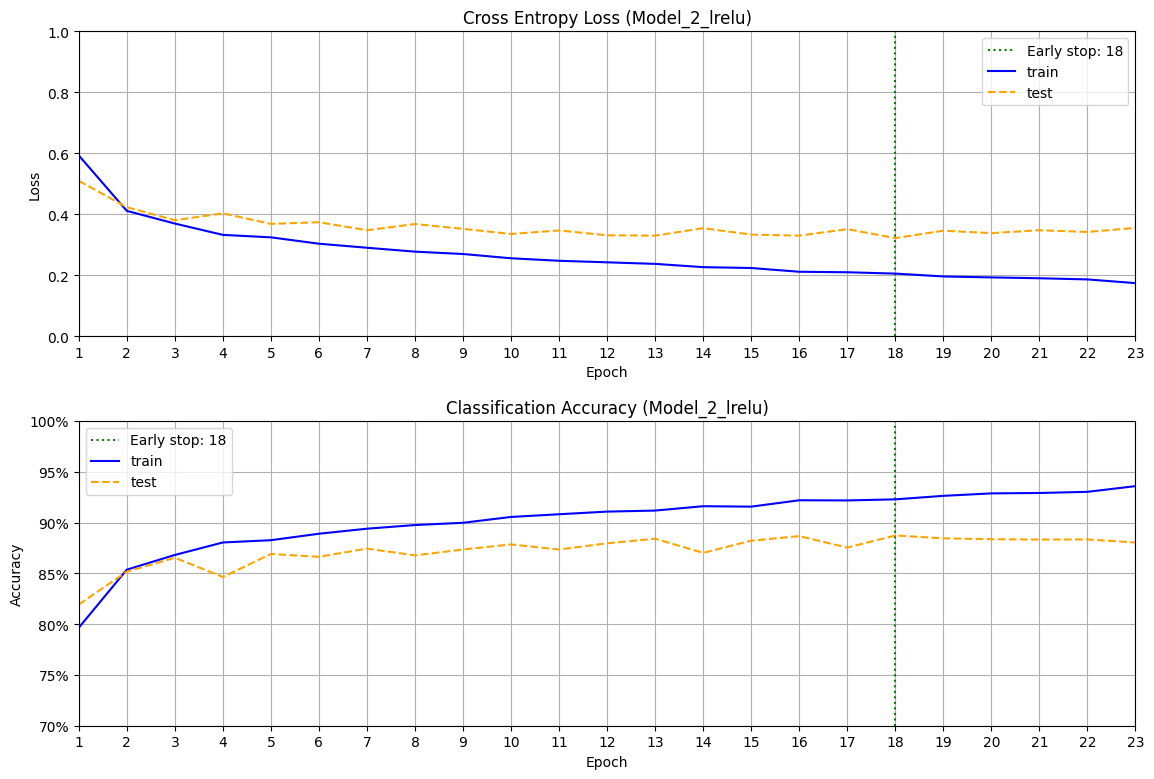

In [85]:
for name, models_h in models_his.items():
  #print(name)
  summarize(models_h, f"({name})", results[name])

## Reports

In [87]:
test_pred_values = {}
for name, models_h in models_his.items():
  print(name,models[name].name)
  test_pred = models[name].predict(x_test, batch_size=batch_size, use_multiprocessing=True)
  test_pred_values[name] = tf.math.argmax(test_pred, axis=1)

Model_1_L2_0.025 Model_1_L2_0.025
20/20 [==============================] - 0s 11ms/step
Model_1_no_reg Model_1_no_reg
20/20 [==============================] - 0s 11ms/step
Model_1_L2_0.1 Model_1_L2_0.1
20/20 [==============================] - 0s 12ms/step
Model_2 Model_2
20/20 [==============================] - 0s 9ms/step
Model_2_L2_0.1 Model_2_L2_0.1
20/20 [==============================] - 0s 9ms/step
Model_2_L2_1 Model_2_L2_1
20/20 [==============================] - 0s 10ms/step
Model_3_DO_0.2 Model_3_DO_0.2
20/20 [==============================] - 0s 9ms/step
Model_3_DO_0.5 Model_3_DO_0.5
20/20 [==============================] - 0s 9ms/step
Model_2_lrelu Model_2_lrelu
20/20 [==============================] - 0s 10ms/step


Classification report for: 'Model_1_L2_0.025'
                 precision    recall  f1-score   support

0 - T-shirt/top       0.78      0.91      0.84      1000
1 - Trouser           0.99      0.96      0.98      1000
2 - Pullover          0.75      0.86      0.80      1000
3 - Dress             0.89      0.88      0.89      1000
4 - Coat              0.82      0.80      0.81      1000
5 - Sandal            0.97      0.97      0.97      1000
6 - Shirt             0.80      0.61      0.69      1000
7 - Sneaker           0.95      0.95      0.95      1000
8 - Bag               0.99      0.96      0.97      1000
9 - Ankle boot        0.96      0.96      0.96      1000

       accuracy                           0.89     10000
      macro avg       0.89      0.89      0.89     10000
   weighted avg       0.89      0.89      0.89     10000

Accuracy: 88.79%
Confusion matrix for: 'Model_1_L2_0.025'


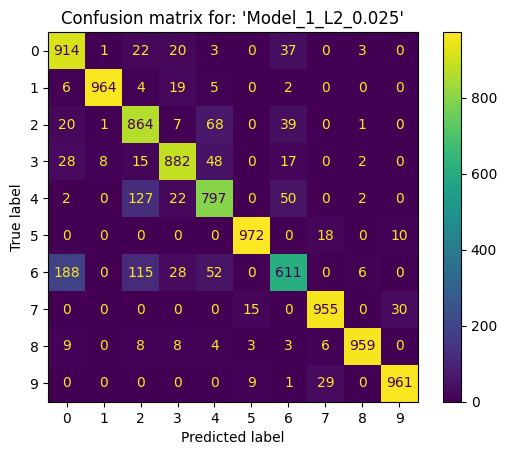

['0 - T-shirt/top', '1 - Trouser', '2 - Pullover', '3 - Dress', '4 - Coat', '5 - Sandal', '6 - Shirt', '7 - Sneaker', '8 - Bag', '9 - Ankle boot']
------------------------------------------------------------ 

Classification report for: 'Model_1_no_reg'
                 precision    recall  f1-score   support

0 - T-shirt/top       0.85      0.82      0.84      1000
1 - Trouser           0.98      0.98      0.98      1000
2 - Pullover          0.84      0.75      0.79      1000
3 - Dress             0.84      0.92      0.88      1000
4 - Coat              0.80      0.82      0.81      1000
5 - Sandal            0.98      0.96      0.97      1000
6 - Shirt             0.71      0.72      0.72      1000
7 - Sneaker           0.94      0.96      0.95      1000
8 - Bag               0.98      0.97      0.98      1000
9 - Ankle boot        0.96      0.96      0.96      1000

       accuracy                           0.89     10000
      macro avg       0.89      0.89      0.89     10000
   

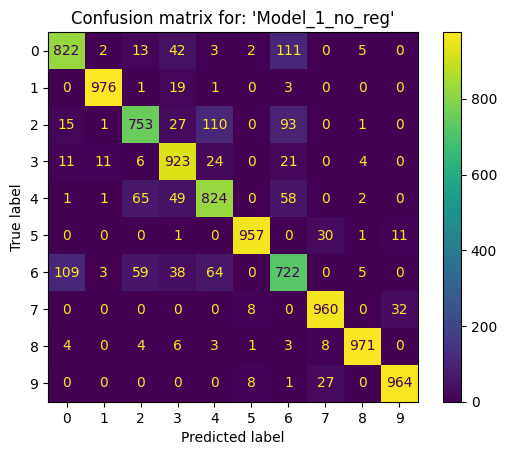

['0 - T-shirt/top', '1 - Trouser', '2 - Pullover', '3 - Dress', '4 - Coat', '5 - Sandal', '6 - Shirt', '7 - Sneaker', '8 - Bag', '9 - Ankle boot']
------------------------------------------------------------ 

Classification report for: 'Model_1_L2_0.1'
                 precision    recall  f1-score   support

0 - T-shirt/top       0.85      0.82      0.83      1000
1 - Trouser           0.99      0.97      0.98      1000
2 - Pullover          0.78      0.82      0.80      1000
3 - Dress             0.88      0.89      0.89      1000
4 - Coat              0.78      0.83      0.81      1000
5 - Sandal            0.96      0.98      0.97      1000
6 - Shirt             0.72      0.68      0.70      1000
7 - Sneaker           0.96      0.95      0.95      1000
8 - Bag               0.98      0.97      0.97      1000
9 - Ankle boot        0.96      0.96      0.96      1000

       accuracy                           0.89     10000
      macro avg       0.89      0.89      0.89     10000
   

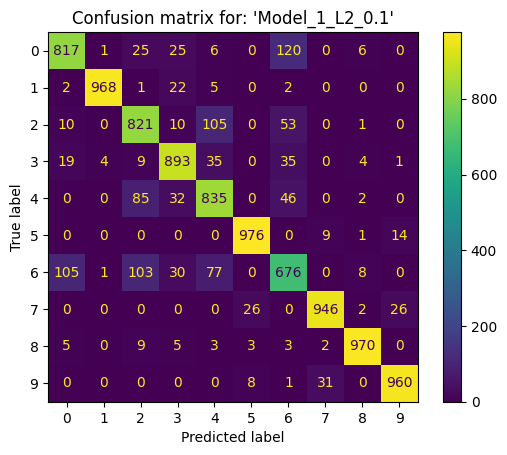

['0 - T-shirt/top', '1 - Trouser', '2 - Pullover', '3 - Dress', '4 - Coat', '5 - Sandal', '6 - Shirt', '7 - Sneaker', '8 - Bag', '9 - Ankle boot']
------------------------------------------------------------ 

Classification report for: 'Model_2'
                 precision    recall  f1-score   support

0 - T-shirt/top       0.85      0.84      0.85      1000
1 - Trouser           1.00      0.97      0.98      1000
2 - Pullover          0.78      0.80      0.79      1000
3 - Dress             0.86      0.91      0.89      1000
4 - Coat              0.80      0.79      0.80      1000
5 - Sandal            0.97      0.97      0.97      1000
6 - Shirt             0.73      0.68      0.71      1000
7 - Sneaker           0.95      0.95      0.95      1000
8 - Bag               0.95      0.98      0.96      1000
9 - Ankle boot        0.96      0.96      0.96      1000

       accuracy                           0.89     10000
      macro avg       0.88      0.89      0.88     10000
   weighte

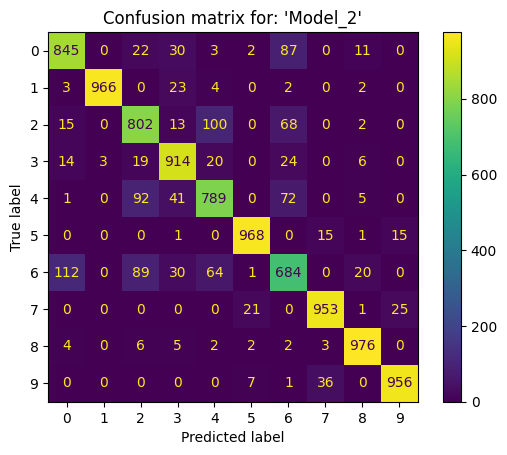

['0 - T-shirt/top', '1 - Trouser', '2 - Pullover', '3 - Dress', '4 - Coat', '5 - Sandal', '6 - Shirt', '7 - Sneaker', '8 - Bag', '9 - Ankle boot']
------------------------------------------------------------ 

Classification report for: 'Model_2_L2_0.1'
                 precision    recall  f1-score   support

0 - T-shirt/top       0.84      0.82      0.83      1000
1 - Trouser           0.98      0.97      0.98      1000
2 - Pullover          0.76      0.84      0.80      1000
3 - Dress             0.88      0.88      0.88      1000
4 - Coat              0.80      0.80      0.80      1000
5 - Sandal            0.97      0.95      0.96      1000
6 - Shirt             0.73      0.65      0.69      1000
7 - Sneaker           0.89      0.98      0.93      1000
8 - Bag               0.96      0.98      0.97      1000
9 - Ankle boot        0.98      0.91      0.94      1000

       accuracy                           0.88     10000
      macro avg       0.88      0.88      0.88     10000
   

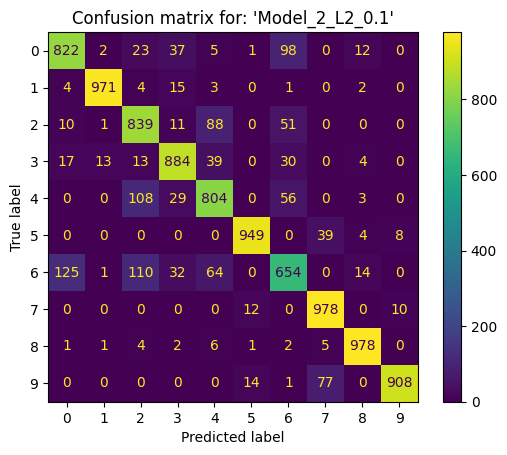

['0 - T-shirt/top', '1 - Trouser', '2 - Pullover', '3 - Dress', '4 - Coat', '5 - Sandal', '6 - Shirt', '7 - Sneaker', '8 - Bag', '9 - Ankle boot']
------------------------------------------------------------ 

Classification report for: 'Model_2_L2_1'
                 precision    recall  f1-score   support

0 - T-shirt/top       0.82      0.82      0.82      1000
1 - Trouser           0.98      0.95      0.97      1000
2 - Pullover          0.76      0.76      0.76      1000
3 - Dress             0.86      0.89      0.87      1000
4 - Coat              0.71      0.86      0.78      1000
5 - Sandal            0.93      0.95      0.94      1000
6 - Shirt             0.73      0.56      0.63      1000
7 - Sneaker           0.94      0.92      0.93      1000
8 - Bag               0.95      0.96      0.96      1000
9 - Ankle boot        0.95      0.95      0.95      1000

       accuracy                           0.86     10000
      macro avg       0.86      0.86      0.86     10000
   we

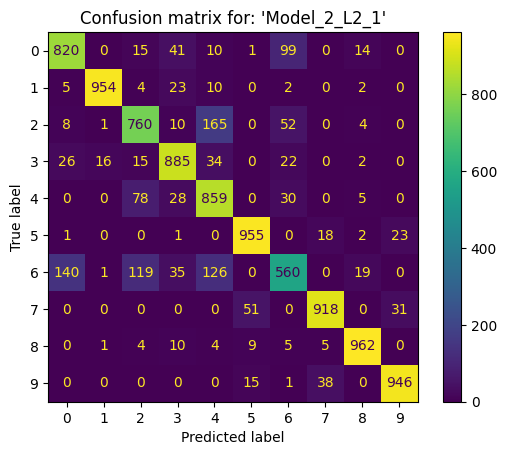

['0 - T-shirt/top', '1 - Trouser', '2 - Pullover', '3 - Dress', '4 - Coat', '5 - Sandal', '6 - Shirt', '7 - Sneaker', '8 - Bag', '9 - Ankle boot']
------------------------------------------------------------ 

Classification report for: 'Model_3_DO_0.2'
                 precision    recall  f1-score   support

0 - T-shirt/top       0.81      0.89      0.85      1000
1 - Trouser           0.99      0.97      0.98      1000
2 - Pullover          0.80      0.82      0.81      1000
3 - Dress             0.91      0.89      0.90      1000
4 - Coat              0.79      0.83      0.81      1000
5 - Sandal            0.98      0.97      0.98      1000
6 - Shirt             0.76      0.64      0.70      1000
7 - Sneaker           0.94      0.97      0.95      1000
8 - Bag               0.98      0.98      0.98      1000
9 - Ankle boot        0.97      0.95      0.96      1000

       accuracy                           0.89     10000
      macro avg       0.89      0.89      0.89     10000
   

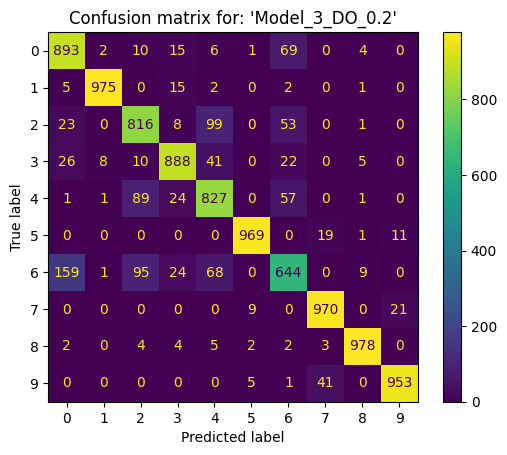

['0 - T-shirt/top', '1 - Trouser', '2 - Pullover', '3 - Dress', '4 - Coat', '5 - Sandal', '6 - Shirt', '7 - Sneaker', '8 - Bag', '9 - Ankle boot']
------------------------------------------------------------ 

Classification report for: 'Model_3_DO_0.5'
                 precision    recall  f1-score   support

0 - T-shirt/top       0.81      0.85      0.83      1000
1 - Trouser           0.99      0.97      0.98      1000
2 - Pullover          0.77      0.79      0.78      1000
3 - Dress             0.86      0.91      0.88      1000
4 - Coat              0.76      0.81      0.78      1000
5 - Sandal            0.99      0.93      0.96      1000
6 - Shirt             0.73      0.59      0.65      1000
7 - Sneaker           0.91      0.97      0.94      1000
8 - Bag               0.98      0.98      0.98      1000
9 - Ankle boot        0.95      0.95      0.95      1000

       accuracy                           0.87     10000
      macro avg       0.87      0.87      0.87     10000
   

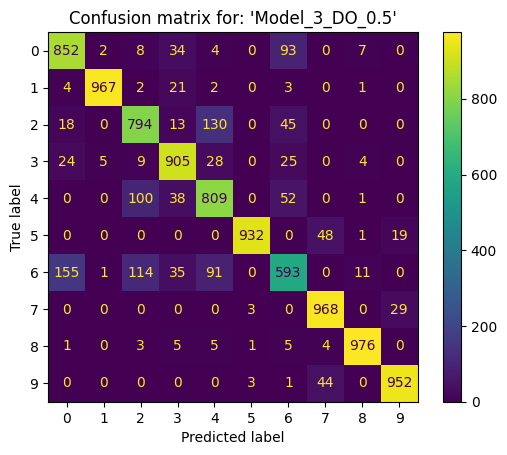

['0 - T-shirt/top', '1 - Trouser', '2 - Pullover', '3 - Dress', '4 - Coat', '5 - Sandal', '6 - Shirt', '7 - Sneaker', '8 - Bag', '9 - Ankle boot']
------------------------------------------------------------ 

Classification report for: 'Model_2_lrelu'
                 precision    recall  f1-score   support

0 - T-shirt/top       0.86      0.82      0.84      1000
1 - Trouser           0.99      0.97      0.98      1000
2 - Pullover          0.87      0.74      0.80      1000
3 - Dress             0.89      0.91      0.90      1000
4 - Coat              0.76      0.88      0.82      1000
5 - Sandal            0.97      0.97      0.97      1000
6 - Shirt             0.69      0.72      0.71      1000
7 - Sneaker           0.91      0.97      0.94      1000
8 - Bag               0.98      0.96      0.97      1000
9 - Ankle boot        0.98      0.92      0.95      1000

       accuracy                           0.89     10000
      macro avg       0.89      0.89      0.89     10000
   w

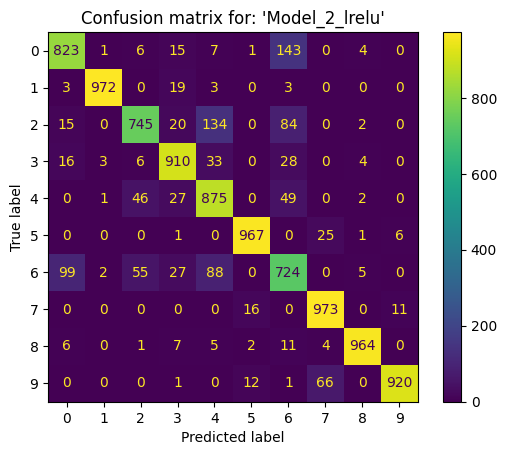

['0 - T-shirt/top', '1 - Trouser', '2 - Pullover', '3 - Dress', '4 - Coat', '5 - Sandal', '6 - Shirt', '7 - Sneaker', '8 - Bag', '9 - Ankle boot']
------------------------------------------------------------ 



In [88]:
target_names = [ f"{i} - {labels[i]:11}" for i in range(0, num_classes)]

for name in models_his.keys():
  print(f"Classification report for: '{name}'")
  print(classification_report(y_test, test_pred_values[name], target_names=target_names))
  cr = classification_report(y_test, test_pred_values[name], target_names=target_names, output_dict=True)
  print(f'Accuracy: {cr["accuracy"]:.2%}')
  print(f"Confusion matrix for: '{name}'")
  confusion_matrix(y_test, test_pred_values[name])
  ConfusionMatrixDisplay.from_predictions(y_test, test_pred_values[name])
  plt.title(f"Confusion matrix for: '{name}'")
  plt.show()
  print(list(map(lambda x: x.strip(),target_names)))
  print("-"*60,"\n")

## Порівняння моделей за val. accur.

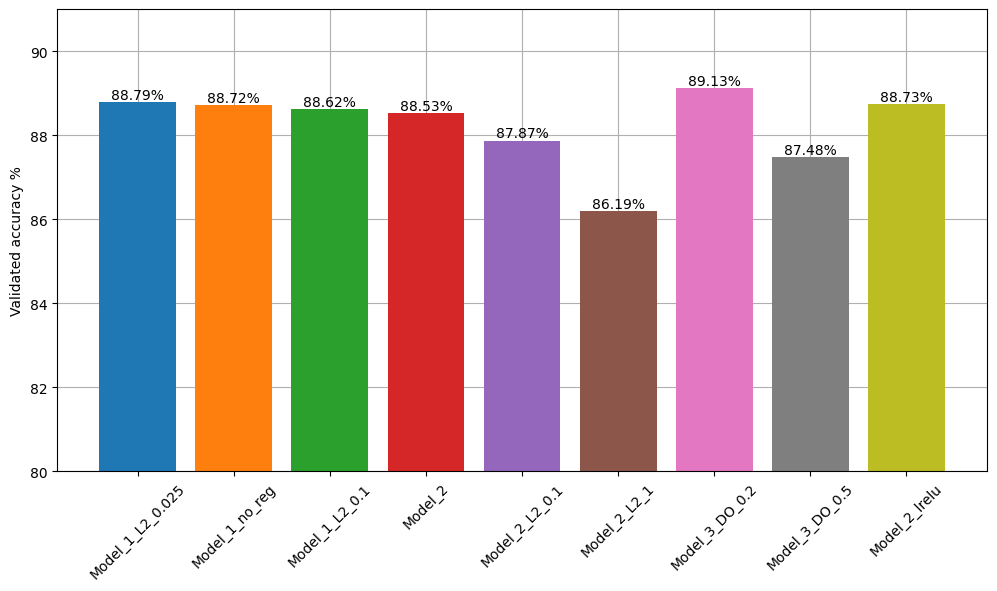

In [89]:
bar_y = [ results[m][1]*100 for m in models ]

plt.figure(figsize=(12,6))
plt.grid()
plt.gca().set_axisbelow(True)
colors = range(len(models))  # Choose the index of the color from the colormap
bars = plt.bar(x=models.keys(), height=bar_y, color=plt.cm.tab10(colors))
for bar, value in zip(bars, bar_y):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{value:.4}%", ha='center', va='bottom')

plt.ylim(80,91)
plt.xticks(rotation=45)
plt.ylabel("Validated accuracy %")
plt.show()

## Візуалізація прогнозу

Model_2


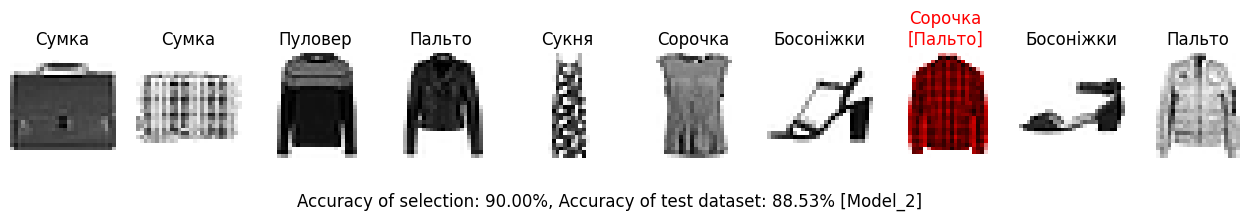

In [90]:
img_selected = 10
random_img_idx = np.random.randint(0, x_test.shape[0], size=img_selected)
#selected_model_name = list(models.keys())[0]
selected_model_name = "Model_2"
print(selected_model_name)
# Plot the images
colors = [(1, 1, 1), (0.8, 0, 0), (0, 0, 0)]  # white, red, black
custom_cmap = plt.cm.colors.LinearSegmentedColormap.from_list("CustomRed", colors, N=256)

plt.figure(figsize=(16, 5))
pred = 0
for i, idx in enumerate(random_img_idx, start=1):
    plt.subplot(1, img_selected, i)
    y_pred = test_pred_values[selected_model_name]

    correct = y_test[idx] == y_pred[idx]
    pred += int(correct)
    cmap = 'gray_r' if correct else custom_cmap
    color = "black" if correct else "red"
    plt.imshow(x_test[idx], cmap=cmap)
    title = labels_uk[y_test[idx]] if correct else f'{labels_uk[y_test[idx]]}\n[{labels_uk[test_pred_values[selected_model_name][idx]]}]'
    plt.title(title, color=color)
    plt.axis('off')

acc = pred/img_selected
plt.suptitle(f"Accuracy of selection: {acc:.2%}, Accuracy of test dataset: {results[selected_model_name][1]:.2%} [{selected_model_name}]")
plt.subplots_adjust(top=2.2)
plt.show()

## Висновок

Використано ряд моделей нейронних мереж для заданого набору данних "Fashion-MNIST".

Для порівняння та вибору найкращої моделі були побудовані декілька моделей з різною кількістю шарів, та різними значеннями гіперпараметрів.

Для забезпечення зупинення перенавчання моделі (overfit) застосовано додавання регуляризатора в одному з шарів типу L2, з різними значеннями. Також протестовано моделі на різних активаційних функціях таких як "relu", та "leaky_relu".

Використано оптимізаційний алгоритм "Adam" для пошуку вагів.

Для автоматичного зупинення пошуку нових ваг для моделі було застосовано "Early stop" як по метриці "val_loss" (min) prop=5, так і по метриці "val_accuracy" (max) prop=10.

Побудовані графіки залежностей для кожної з моделей, з відображенням найкращої епохи для вагів, котрі були вибранні. Де можна побачити тенденцію моделі до перенавчання.

Завдяки застосуванню "Early stop" загальні характеристики моделей у на діаграмі "Validated accuracy" певним чином вирівнялися, і перенавчання своєчасно було зупинено.

Вибір найкращої моделі базується на її простоті, швидкості та якості за мінімальними значеннями втрат "val_loss", та максимальним значенням якості "val_accuracy".

За вибраною моделлю "Model_2" побудовані випадкові передбачення для 10 зображень з тестової вибірки набору даних та результати побачення де червоний колір означає передбачення було помилкове.

За значеннями результатів confusion matrix бачимо що найгірша ситуація з прогнозуванням категорії 6 - 'Shirt' [Сорочка] яка має найбільшу кількість помилок з категорією 0 'T-shirt/top' [Футболка/Топ] та '4 - Coat' [Пальто], що і показала тестова вибірка.

